In [1]:
import numpy as np
import matplotlib.pyplot as plt

import skimage
from skimage.color import rgb2gray,rgba2rgb
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

from HAPPY import import_image
from HAPPY import cropping_functions as crop
from HAPPY import plot_functions as plt_f
from HAPPY import radial_hydride_fraction as RHF
from HAPPY import branching as branch
from HAPPY import crack_path as cp
from HAPPY import image_processing
from HAPPY import threshold
from HAPPY.exposure import histogram

%matplotlib inline

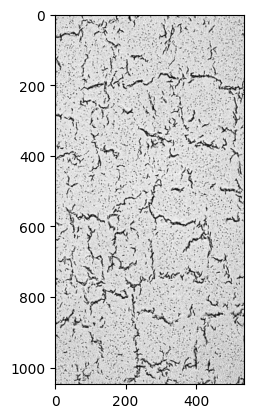

In [2]:
img = skimage.io.imread('data/Micrographs_Used_To_Test_Code/1805A(236).bmp')
img = crop.cropImage(img,500,500,500,500)
plt.imshow(img,cmap='gray')

Felzenszwalb number of segments: 1448
SLIC number of segments: 242
Quickshift number of segments: 4146
Watershed number of segments: 242


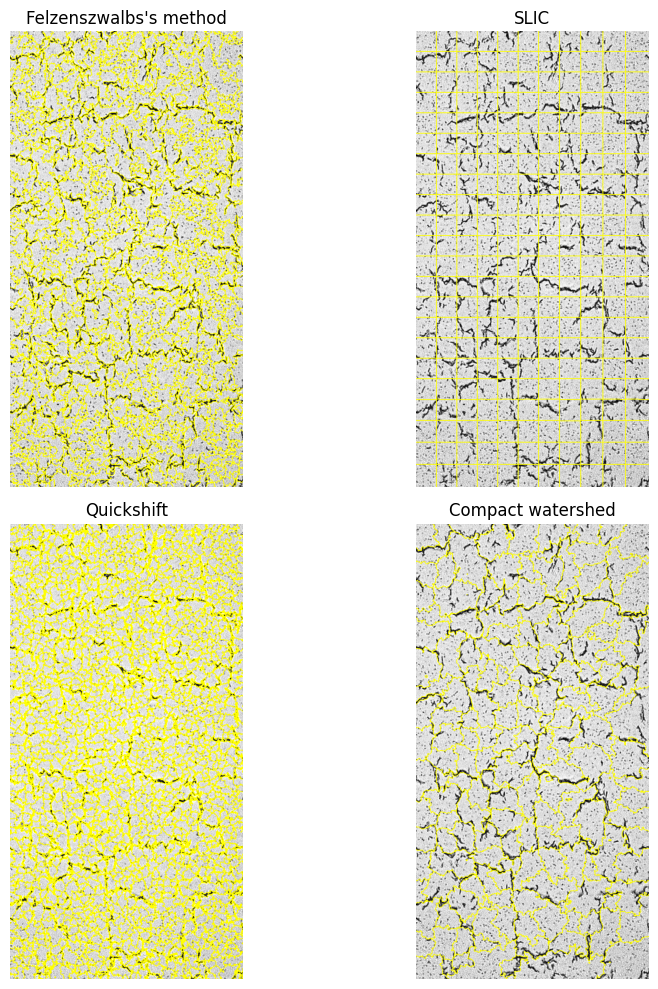

In [3]:
#img = img_as_float(astronaut()[::2, ::2])

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1, start_label=1,channel_axis=None)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)
#segments_cv = skimage.segmentation.chan_vese(img)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic[:,:,1]))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [4]:
def plot_thres(img_fpath,transpose=False,bottom_crop=50,scale=None, location=None, ax=None):
    """Plotting an imge.
    
    Parameters
    ----------
    img : array
        Image data to be plotted
    title : str
        Title of plot.
    scale : float
        Scale in meters per pixel.
    location : str
        Location of scale bar i.e. 'lower right', 'upper left'
    """
    img,crop_threshold = produce_cropped_image(img_fpath,transpose=transpose,bottom_crop=bottom_crop)
    
    li_thres = threshold.threshold_li(img)
    otsu_thres = threshold.threshold_otsu(img)
    tri_thres = threshold.threshold_triangle(img)
    yen_thres = threshold.threshold_yen(img)
    iso_thres = threshold.threshold_isodata(img)
    

    
    print(f'Li:{li_thres}')
    print(f'Otsu:{otsu_thres}')
    print(f'Triangle:{tri_thres}')
    print(f'Yen:{yen_thres}')
    print(f'Isodata:{iso_thres}')

    li_image = image_processing.simple_threshold(img,scale_um, crop_threshold, 
                                          threshold = li_thres, small_obj = 40)
    otsu_image = image_processing.simple_threshold(img,scale_um, crop_threshold, 
                                          threshold = otsu_thres, small_obj = 40)
    tri_image = image_processing.simple_threshold(img,scale_um, crop_threshold, 
                                          threshold = tri_thres, small_obj = 40)
    yen_image = image_processing.simple_threshold(img,scale_um, crop_threshold, 
                                          threshold = yen_thres, small_obj = 40)
    iso_image = image_processing.simple_threshold(img,scale_um, crop_threshold, 
                                          threshold = iso_thres, small_obj = 40)
    
    images = [img, li_image, tri_image, yen_image, iso_image, otsu_image]
    titles = ["Original", "Li", "Triangle", "Yen", "Isodata", "Otsu"]
    
    # Set up a 2x3 grid for the images
    fig, axs = plt.subplots(3, 2, figsize=(12, 8))  # Adjust figsize as needed
    
    # Flatten the 2x3 array of axes to make iteration easier
    axs = axs.flatten()
    
    # Loop over each image and corresponding title
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img, cmap='gray')  # Use cmap='gray' for grayscale, remove it for color
        axs[i].set_title(title)
        axs[i].axis('off')  # Hide the axes
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

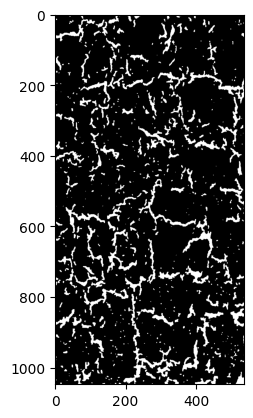

In [7]:
segments_cv = skimage.segmentation.chan_vese(rgb2gray(img))
plt.imshow(segments_cv,cmap='gray')
#plt.imshow(mark_boundaries(rgb2gray(img),segments_cv))

In [6]:
segments_cv

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [5]:
img.shape

(2048, 1286, 3)

In [17]:
img2 = crop.cropImage(img,00,500,500,500)

CPU times: user 855 ms, sys: 253 ms, total: 1.11 s
Wall time: 1.1 s


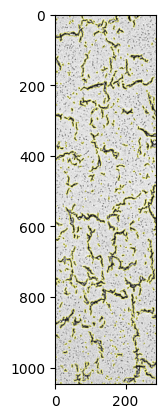

In [18]:
%%time
segments_cv = skimage.segmentation.chan_vese(rgb2gray(img2))
plt.imshow(mark_boundaries(rgb2gray(img2),segments_cv))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (
    morphological_chan_vese,
    morphological_geodesic_active_contour,
    inverse_gaussian_gradient,
    checkerboard_level_set,
)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Morphological ACWE
image = img_as_float(img)

# Initial level set
init_ls = checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(
    image, num_iter=35, init_level_set=init_ls, smoothing=3, iter_callback=callback
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label("Iteration 7")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 35")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)


# Morphological GAC
image = img_as_float(data.coins())
gimage = inverse_gaussian_gradient(image)

# Initial level set
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_geodesic_active_contour(
    gimage,
    num_iter=230,
    init_level_set=init_ls,
    smoothing=1,
    balloon=-1,
    threshold=0.69,
    iter_callback=callback,
)

ax[2].imshow(image, cmap="gray")
ax[2].set_axis_off()
ax[2].contour(ls, [0.5], colors='r')
ax[2].set_title("Morphological GAC segmentation", fontsize=12)

ax[3].imshow(ls, cmap="gray")
ax[3].set_axis_off()
contour = ax[3].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[3].contour(evolution[100], [0.5], colors='y')
contour.collections[0].set_label("Iteration 100")
contour = ax[3].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 230")
ax[3].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[3].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()